In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, classification_report

## Load data

In [2]:
train_df = pd.read_csv("/content/split_train.csv")
val_df = pd.read_csv("/content/split_val.csv")
test_df = pd.read_csv("/content/split_test.csv")

train_df.shape, val_df.shape, test_df.shape

((21004, 21), (4501, 21), (4491, 21))

In [7]:
# Installer le package Kaggle
!pip install kaggle

# Créer un répertoire pour stocker les informations d'identification Kaggle
!mkdir -p ~/.kaggle

# Télécharger le fichier kaggle.json contenant vos informations d'identification
# Assurez-vous d'avoir téléchargé ce fichier sur votre environnement Colab
from google.colab import files

files.upload()

# Déplacer le fichier kaggle.json dans le répertoire .kaggle et définir les permissions appropriées
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger les données de la compétition Kaggle
!kaggle competitions download -c multi-label-classification-competition-2023

# Décompresser les données téléchargées
!unzip multi-label-classification-competition-2023.zip -d data

# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, classification_report

# Vous pouvez maintenant charger et explorer vos données
# Par exemple :
# df = pd.read_csv('data/train.csv')
# print(df.head())

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/COMP5329S1A2Dataset/data/550.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5500.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5501.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5502.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5503.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5504.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5505.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5506.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5507.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5508.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5509.jpg  
  inflating: data/COMP5329S1A2Dataset/data/551.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5510.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5511.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5512.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5513.jpg  
  inflating: data/COMP5329S1A2Dataset/data/5514.jpg  
  infl

In [ ]:
# Update file paths to point to the unzipped files
train_df = pd.read_csv(
    "/content/multi-label-classification-competition-2023/split_train.csv"
)
val_df = pd.read_csv(
    "/content/multi-label-classification-competition-2023/split_val.csv"
)
test_df = pd.read_csv(
    "/content/multi-label-classification-competition-2023/split_test.csv"
)

train_df.shape, val_df.shape, test_df.shape

## Preprocess data

In [8]:
# Function to load images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize for model input
    image = image / 255.0  # normalize
    return image


def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

In [9]:
# Convert one-hot labels to numpy array
labels_array = np.array(train_df.iloc[:, 3:].values)

class_counts = labels_array.sum(axis=0)  # Count samples per class

# Compute class weights (inverse frequency)
class_weights = {
    i: len(labels_array) / (len(class_counts) * class_counts[i])
    for i in range(len(class_counts))
}


# Function to compute sample weights based on the labels
def compute_sample_weights(labels, class_weights):
    return np.array(
        [
            sum(class_weights[i] * label[i] for i in range(len(label)))
            for label in labels
        ]
    )


# Compute sample weights for each sample
sample_weights = compute_sample_weights(labels_array, class_weights)
print(sample_weights)

[2.28544193 0.84926411 1.58254858 ... 2.70125709 3.23326976 1.50955872]


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                "data/COMP5329S1A2Dataset/data/" + train_df["ImageID"]
            ).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(train_df.iloc[:, 3:].values)
            ),
            tf.data.Dataset.from_tensor_slices(
                sample_weights
            ),  # Add sample weights to dataset
        )
    )
    .batch(32)
    .prefetch(1)
)

val_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                "data/COMP5329S1A2Dataset/data/" + val_df["ImageID"]
            ).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(val_df.iloc[:, 3:].values)
            ),  # Assuming labels are in columns 1 to n
        )
    )
    .batch(32)
    .prefetch(1)
)

test_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                "data/COMP5329S1A2Dataset/data/" + test_df["ImageID"]
            ).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(test_df.iloc[:, 3:].values)
            ),  # Assuming labels are in columns 1 to n
        )
    )
    .batch(32)
    .prefetch(1)
)

In [11]:
for img, label, _ in train_ds.take(1):
    print(img.shape, label.shape)  # Check the shape of the images and labels
    print(label)  # Check the labels

(32, 224, 224, 3) (32, 18)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 

## Conception du CNN

### Base CNN

In [30]:
from tensorflow.keras import layers, models


# Define the minimal CNN architecture
def create_minimal_cnn(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))

    return model


# Example usage
input_shape = (224, 224, 3)  # Example input shape for images
num_classes = len(train_df.columns[3:])  # Number of classes based on the labels
model = create_minimal_cnn(input_shape, num_classes)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),  # Adjust num_labels as needed
        "accuracy",
        tf.keras.metrics.Precision(),
    ],
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,712,338 (98.08 MB)

 Trainable params: 25,712,146 (98.08 MB)

 Non-trainable params: 192 (768.00 B)

In [31]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

model.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

# Evaluate model
print("Evaluating model...")
model.evaluate(test_ds.map(lambda img, label: (img, label)), verbose=1)

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/step - AUC: 0.5241 - accuracy: 0.6047 - loss: 1.8459 - precision_1: 0.6505 - val_AUC: 0.5758 - val_accuracy: 0.7318 - val_loss: 0.2237 - val_precision_1: 0.7615
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - AUC: 0.5799 - accuracy: 0.7443 - loss: 0.2147 - precision_1: 0.7680 - val_AUC: 0.6045 - val_accuracy: 0.7521 - val_loss: 0.2012 - val_precision_1: 0.7538
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - AUC: 0.6196 - accuracy: 0.7548 - loss: 0.1995 - precision_1: 0.7715 - val_AUC: 0.5853 - val_accuracy: 0.7525 - val_loss: 0.2157 - val_precision_1: 0.7526
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - AUC: 0.6493 - accuracy: 0.7562 - loss: 0.1918 - precision_1: 0.7715 - val_AUC: 0.6198 - val_accuracy: 0.7525 - val_loss: 0.1995 - val_precision_1: 0.7523
Epoch 5/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - AUC: 0.6709 - accuracy: 0.7564 - loss: 0.1870 - precision_1: 0.7686 - val_AUC: 0.6442 - val_accuracy: 0.7525 

[0.1935039907693863,
 0.6409451365470886,
 0.7615230679512024,
 0.7628032565116882]

La metrique adaptée pour ce problème est **Mean Average Precision** car :
*  Nous faisons une classification multi-label
* On a un gros desequilibre au niveau des classes

En second, on peut utiliser **F1 score** car, on a la possibilité de gérer le desequilibre des classes en utilisant le macro F1 score.

In [14]:
import matplotlib.pyplot as plt


def plot_training_history(history, model_name="Text Model", metrics=["AUC", "loss"]):
    i = 0
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))
    fig.suptitle(f"{model_name} Training History", fontsize=16)

    for metric in metrics:
        if metric not in history.history:
            raise ValueError(f"Metric '{metric}' not found in history.")
        axes[i].plot(history.history[metric], label="Train " + metric)
        axes[i].plot(history.history["val_" + metric], label="Val " + metric)
        axes[i].set_title(f"{model_name} {metric}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric)
        axes[i].legend()

        i += 1

    plt.show()

In [15]:
def multi_label_threshold(y_pred, threshold=0.5, threshold_nb=None):
    if threshold_nb is not None:
        y_pred_top3 = np.zeros_like(y_pred, dtype=int)
        for i in range(len(y_pred)):
            top_indices = np.argsort(y_pred[i])[-threshold_nb:]
            y_pred_top3[i, top_indices] = 1

        return y_pred_top3

    return (y_pred > threshold).astype(int)

In [16]:
def mean_avg_precision(y_true, y_pred):
    precision = []
    for i in range(len(y_true)):
        true_positives = np.sum(y_true.iloc[i].values & y_pred[i])
        predicted_positives = np.sum(y_pred[i])
        if predicted_positives > 0:
            precision.append(true_positives / predicted_positives)
        else:
            precision.append(0)

    avg_precision = np.mean(precision)
    return avg_precision

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def confusion_matrice_multilabel(y_true, y_pred, labels):
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for Logistic Regression Model")
    plt.show()

ValueError: Metric 'AUC' not found in history.

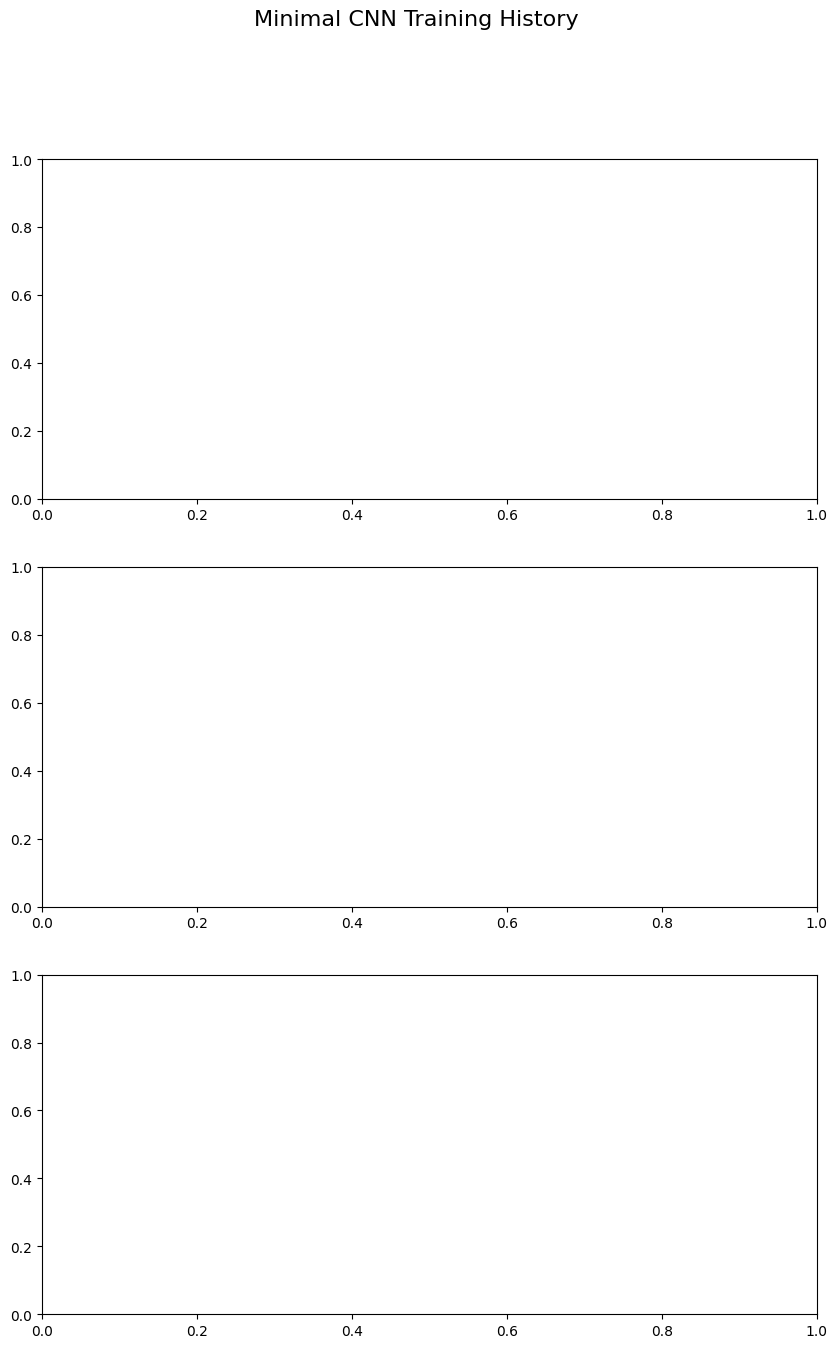

In [35]:
plot_training_history(
    model.history, model_name="Minimal CNN", metrics=["AUC", "loss", "accuracy"]
)

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
Mean Average Precision: 0.7389

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.19      0.90      0.32       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.30      0.19      0.23       209
           7       0.00      0.00      0.00       183
           8       0.26      0.18      0.21       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.07      0.74      0.13       290
          16       0.00      0.00      0.00       165
          17       0.08

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


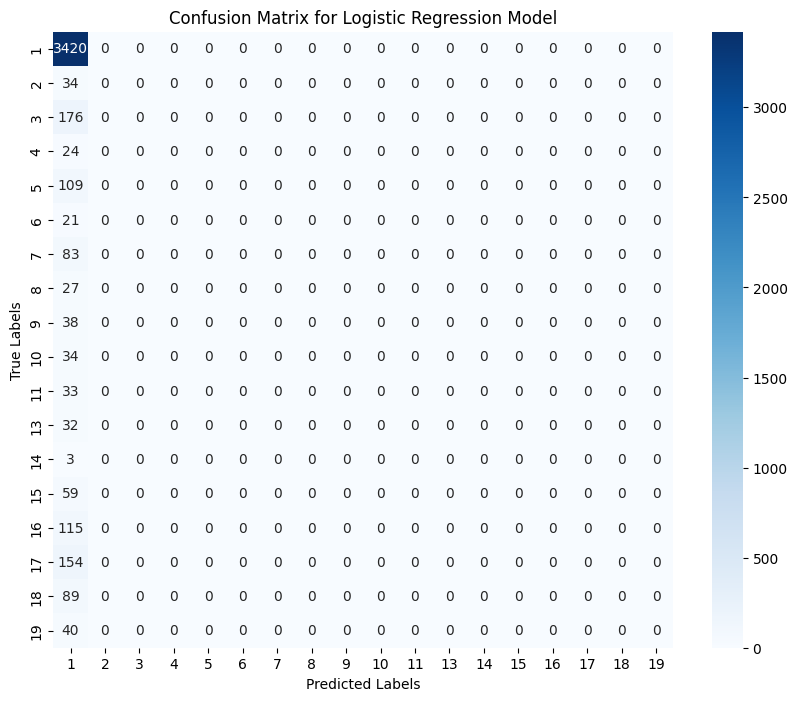

In [36]:
y_pred = model.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

y_true = test_df.iloc[:, 3:].values  # Assuming labels are in columns 1 to n

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision: {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

### CNN avancées

#### ResNet

##### Expérimentation 1

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Implemente RESNET
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

# Ajouter les nouvelles couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

# creation du modele
model_resnet = Model(inputs=base_model.input, outputs=outputs)

model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

# Afficher le résumé du modèle
model_resnet.summary()

In [39]:
model_resnet.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

# Evaluate the model
print("Evaluating model...")
model_resnet.evaluate(test_ds.map(lambda img, label: (img, label)), verbose=1)

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 100s 131ms/step - AUC: 0.5010 - accuracy: 0.3691 - loss: 120.4831 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 155.7371
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - AUC: 0.4998 - accuracy: 0.3442 - loss: 717.3565 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 263.9575
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - AUC: 0.4998 - accuracy: 0.3290 - loss: 1379.2682 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 376.8872
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - AUC: 0.4987 - accuracy: 0.3204 - loss: 2262.8457 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 529.9780
Evaluating model...
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - AUC: 0.4977 - accuracy: 0.7688 - loss: 149.8123


[156.13446044921875, 0.7615230679512024, 0.5]

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step
Mean Average Precision pour : 0.6933

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      1.00      0.25       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.00      0.00      0.00       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.06      1.00      0.12       290
          16       0.00      0.00      0.00       165
          17   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


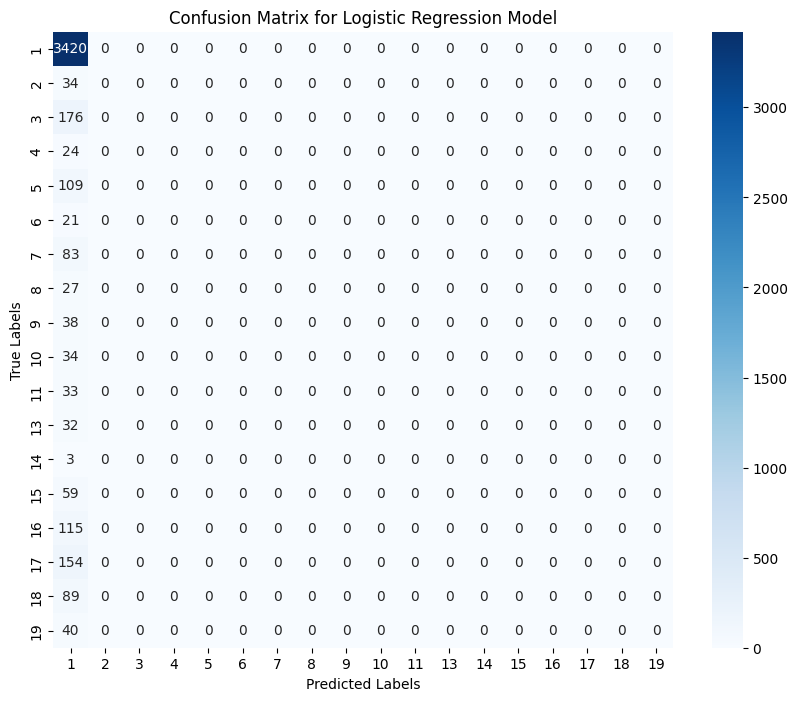

In [40]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = model_resnet.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Expérimentation 2

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(train_df.columns[3:]), activation="softmax")(x)

# Création du modèle final
fine_tune_model_resnet = Model(inputs=base_model.input, outputs=outputs)

fine_tune_model_resnet = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    # Dégeler uniquement les couches du dernier bloc qui sont plus specifiques a la tache a effectuer
    if "conv5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Reduire le taux d'apprentissage pour eviter de trop modifier les poids deja appris
fine_tune_model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

fine_tune_model_resnet.summary()

In [42]:
fine_tune_model_resnet.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

# Evaluate the model
print("Evaluating model...")
fine_tune_model_resnet.evaluate(test_ds.map(lambda img, label: (img, label)), verbose=1)

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 131s 167ms/step - AUC: 0.4997 - accuracy: 0.3661 - loss: 3334.6626 - val_AUC: 0.5023 - val_accuracy: 0.0438 - val_loss: 16122.3906
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - AUC: 0.4971 - accuracy: 0.3468 - loss: 64416.8594 - val_AUC: 0.5000 - val_accuracy: 0.0438 - val_loss: 41012.2070
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 104s 158ms/step - AUC: 0.4988 - accuracy: 0.3557 - loss: 263158.8438 - val_AUC: 0.5000 - val_accuracy: 0.0438 - val_loss: 109251.2266
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 96s 145ms/step - AUC: 0.5001 - accuracy: 0.3570 - loss: 653504.8750 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 262270.2812
Evaluating model...
141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - AUC: 0.5010 - accuracy: 0.0353 - loss: 15910.7646


[15933.7412109375, 0.03918949142098427, 0.5033976435661316]

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step
Mean Average Precision pour : 0.4046

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      1.00      0.25       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.00      0.00      0.00       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       290
          16       0.00      0.00      0.00       165
          17   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


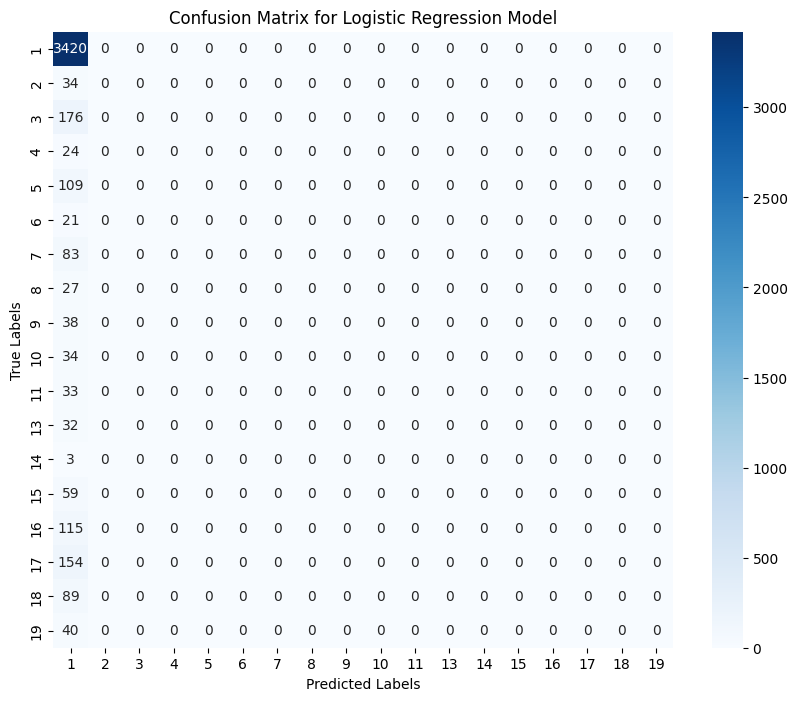

In [43]:
from sklearn.metrics import average_precision_score, classification_report


y_pred = fine_tune_model_resnet.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Expérimentation 3

In [ ]:
base_scratch_model_resnet = ResNet50(
    weights=None, include_top=False, input_shape=input_shape
)

x = base_scratch_model_resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(train_df.columns[3:]), activation="softmax")(x)

model_scratch_resnest = Model(inputs=base_scratch_model_resnet.input, outputs=outputs)

model_scratch_resnest.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

model_scratch_resnest.summary()

In [45]:
model_scratch_resnest.fit(
    train_ds.map(lambda img, label, weight: (img, label, weight)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

# Evaluate the model
print("Evaluating model...")
model_scratch_resnest.evaluate(test_ds.map(lambda img, label: (img, label)), verbose=1)

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 293s 358ms/step - AUC: 0.4975 - accuracy: 0.3389 - loss: 2932.4114 - val_AUC: 0.4928 - val_accuracy: 0.7525 - val_loss: 6619.4155
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 206s 313ms/step - AUC: 0.4915 - accuracy: 0.3300 - loss: 41430.1602 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 57123.6484
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 206s 313ms/step - AUC: 0.4975 - accuracy: 0.3524 - loss: 177242.0000 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 183452.8281
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 205s 313ms/step - AUC: 0.4989 - accuracy: 0.3598 - loss: 466015.8438 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 396444.9062
Evaluating model...
141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - AUC: 0.4903 - accuracy: 0.7688 - loss: 6491.4414


[6653.2900390625, 0.7615230679512024, 0.4935400187969208]

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step
Mean Average Precision pour : 0.6401

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.04      0.03      0.04       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.00      0.00      0.00       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.03      0.02      0.02       290
          16       0.00      0.00      0.00       165
          17   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


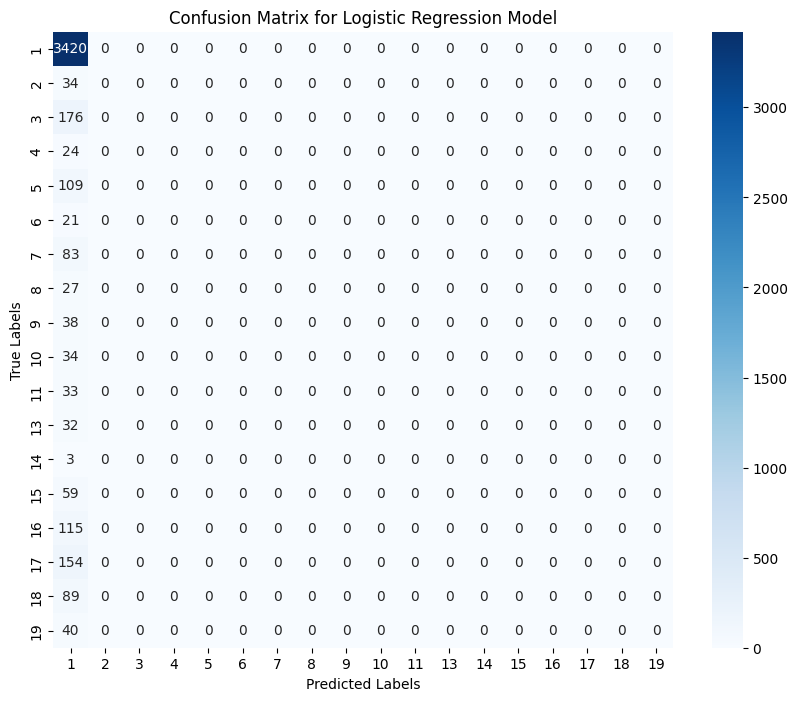

In [46]:
y_pred = model_scratch_resnest.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Compare

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 161.0924
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - AUC: 0.5004 - accuracy: 0.0460 - loss: 16252.0508
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - AUC: 0.4886 - accuracy: 0.7517 - loss: 6845.5020
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 161.0924
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - AUC: 0.5004 - accuracy: 0.0460 - loss: 16252.0508
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - AUC: 0.4886 - accuracy: 0.7517 - loss: 6845.5020
Comparaison des performances:
               Modèle  Accuracy       AUC
0            Resnet50  0.752499  0.500000
1  Fine-tune ResNet50  0.043768  0.502267
2    ResNet50 Scratch  0.752499  0.492844


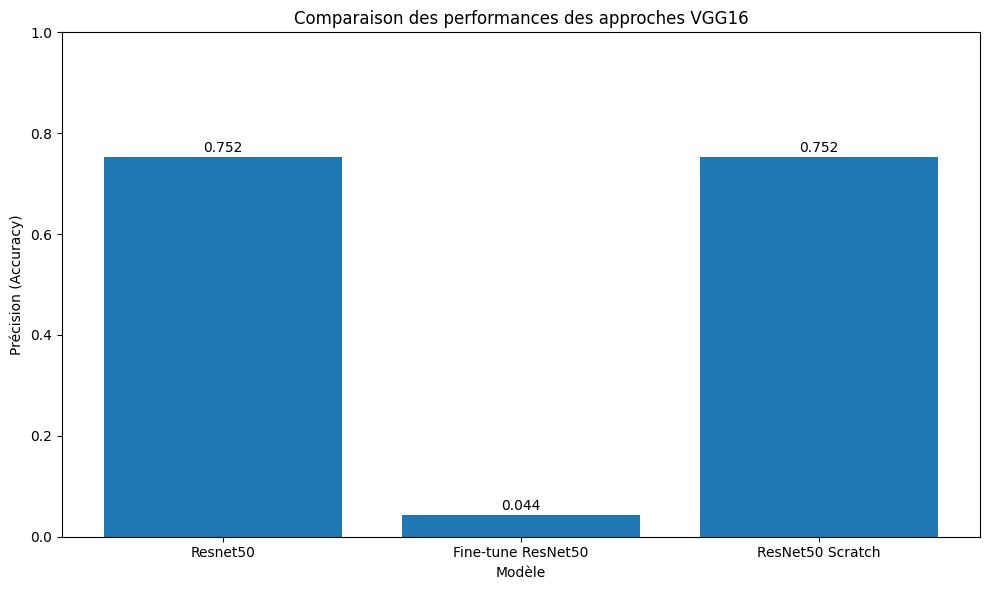

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Supposons que nous avons stocké les métriques d'évaluation
metrics = {
    "Modèle": ["Resnet50", "Fine-tune ResNet50", "ResNet50 Scratch"],
    "Accuracy": [
        model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        fine_tune_model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
        model_scratch_resnest.evaluate(val_ds.map(lambda img, label: (img, label)))[1],
    ],
    "AUC": [
        model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        fine_tune_model_resnet.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
        model_scratch_resnest.evaluate(val_ds.map(lambda img, label: (img, label)))[2],
    ],
}

df_metrics = pd.DataFrame(metrics)
print("Comparaison des performances:")
print(df_metrics)

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Modèle"], df_metrics["Accuracy"])
plt.title("Comparaison des performances des approches VGG16")
plt.xlabel("Modèle")
plt.ylabel("Précision (Accuracy)")
plt.ylim(0, 1)
for i, v in enumerate(df_metrics["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()

#### EfficientNet

##### Experimentation 1

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights="imagenet", include_top=False, input_shape=input_shape
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(train_df.columns[3:]), activation="softmax")(x)

model_eff_transfer = Model(inputs=base_model.input, outputs=outputs)

model_eff_transfer.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

model_eff_transfer.summary()

In [49]:
callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model_eff_transfer.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

print("Évaluation du modèle EfficientNet (transfert d'apprentissage):")
model_eff_transfer.evaluate(val_ds.map(lambda img, label: (img, label)))

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - AUC: 0.4994 - accuracy: 0.5678 - loss: 28.4089 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 57.7407
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - AUC: 0.5001 - accuracy: 0.5119 - loss: 77.6167 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 93.5274
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - AUC: 0.5002 - accuracy: 0.5047 - loss: 120.3851 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 134.8595
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - AUC: 0.4992 - accuracy: 0.5124 - loss: 162.8972 - val_AUC: 0.4985 - val_accuracy: 0.7525 - val_loss: 156.3381
Évaluation du modèle EfficientNet (transfert d'apprentissage):
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 60.4056


[57.74074935913086, 0.7524994611740112, 0.5]

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step
Mean Average Precision pour : 0.7214

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      1.00      0.25       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.07      1.00      0.14       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       290
          16       0.00      0.00      0.00       165
          17    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


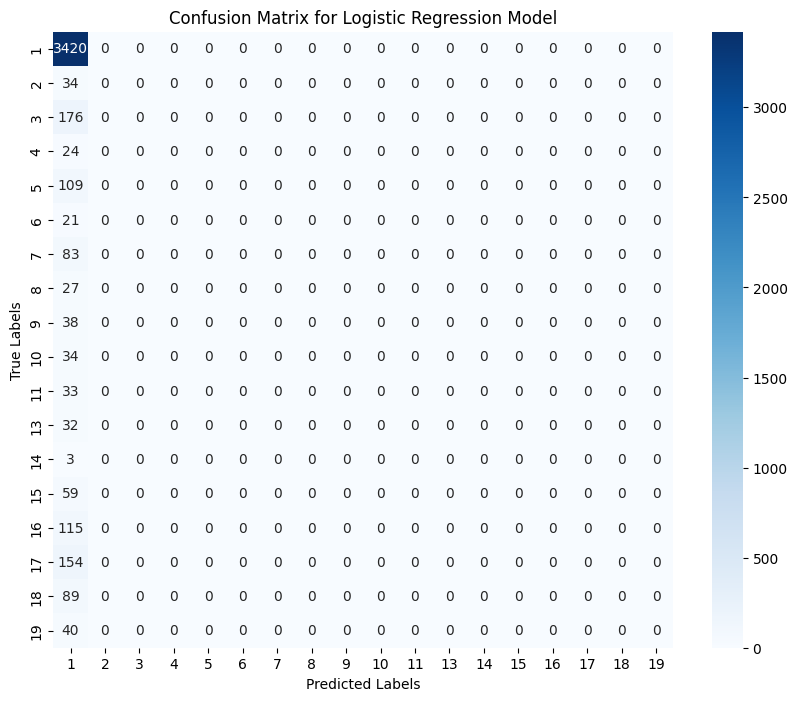

In [50]:
y_pred = model_eff_transfer.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Experimentation 2

In [ ]:
base_model = EfficientNetB0(
    weights="imagenet", include_top=False, input_shape=input_shape
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(train_df.columns[3:]), activation="softmax")(x)

model_eff_finetune = Model(inputs=base_model.input, outputs=outputs)

# 4. Phase 1 : Entraînement avec toutes les couches de base gelées
for layer in base_model.layers:
    if "block5" in layer.name or "block4" in layer.name:
        layer.trainable = True

model_eff_finetune.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

model_eff_finetune.summary()

In [52]:
model_eff_finetune.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

print("Évaluation du modèle EfficientNetB0 (fine-tuning):")
model_eff_finetune.evaluate(val_ds.map(lambda img, label: (img, label)))

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 205s 203ms/step - AUC: 0.5144 - accuracy: 0.6946 - loss: 35.4395 - val_AUC: 0.5002 - val_accuracy: 0.7525 - val_loss: 4.2321
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 126s 141ms/step - AUC: 0.4960 - accuracy: 0.6029 - loss: 372.1273 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 15.3397
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 139ms/step - AUC: 0.5029 - accuracy: 0.5257 - loss: 1085.8451 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 27.6475
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - AUC: 0.5048 - accuracy: 0.5225 - loss: 2248.8394 - val_AUC: 0.4974 - val_accuracy: 0.7405 - val_loss: 6701.1880
Évaluation du modèle EfficientNetB0 (fine-tuning):
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - AUC: 0.4962 - accuracy: 0.7517 - loss: 4.2958


[4.232052326202393, 0.7524994611740112, 0.5002425909042358]

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step
Mean Average Precision pour : 0.7204

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      1.00      0.25       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.00      0.00      0.00       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       290
          16       0.00      0.00      0.00       165
          17    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


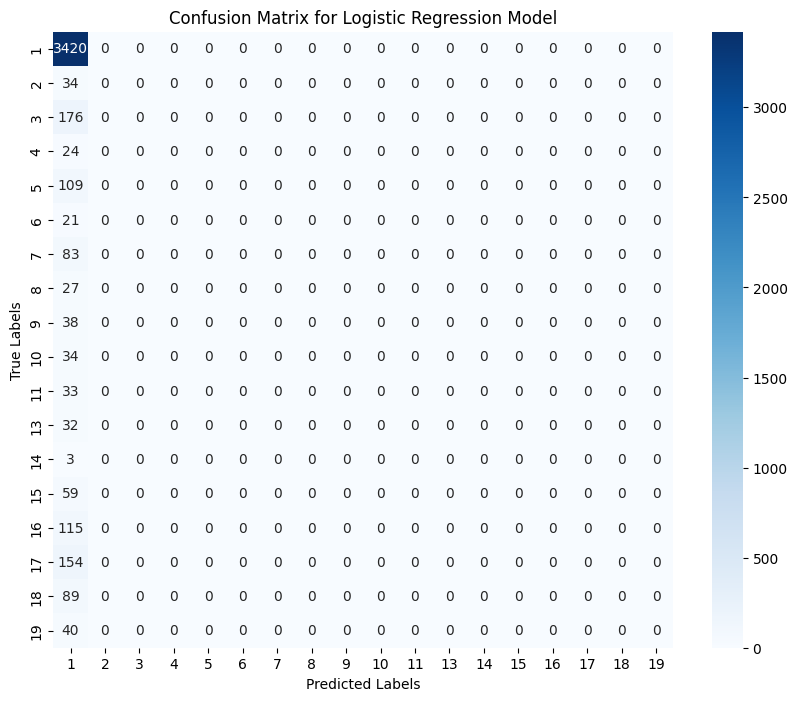

In [53]:
y_pred = model_eff_finetune.predict(test_ds.map(lambda img, label: (img, label)))

y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Experimentation 3

In [54]:
base_scratch_model_eff = EfficientNetB0(
    weights=None,  # Pas de poids préentraînés
    include_top=False,
    input_shape=(224, 224, 3),
)

x = base_scratch_model_eff.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(train_df.columns[3:]), activation="softmax")(x)

scratch_model_eff = Model(inputs=base_scratch_model_eff.input, outputs=outputs)

scratch_model_eff.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            name="AUC", multi_label=True, num_labels=len(train_df.columns[3:])
        ),
    ],
)

scratch_model_eff.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization_2[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 4,714,677 (17.99 MB)

 Trainable params: 4,672,654 (17.82 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [55]:
scratch_model_eff.fit(
    train_ds.map(lambda img, label, weight: (img, label)),
    epochs=5,
    validation_data=val_ds.map(lambda img, label: (img, label)),
    callbacks=[callback],
)

print("Évaluation du modèle EfficientNetB0 (scratch):")
scratch_model_eff.evaluate(val_ds.map(lambda img, label: (img, label)))

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 199s 199ms/step - AUC: 0.4990 - accuracy: 0.5965 - loss: 301.4010 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 575.2864
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 139ms/step - AUC: 0.4996 - accuracy: 0.5180 - loss: 4686.5801 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 16416.3027
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 143s 140ms/step - AUC: 0.4987 - accuracy: 0.5145 - loss: 11731.0938 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 23824.9141
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 97s 148ms/step - AUC: 0.5012 - accuracy: 0.5057 - loss: 27701.2832 - val_AUC: 0.5000 - val_accuracy: 0.7525 - val_loss: 65468.7383
Évaluation du modèle EfficientNetB0 (scratch):
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 574.3469


[575.2864379882812, 0.7524994611740112, 0.5]

141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step
Mean Average Precision pour : 0.6774

Rapport de classification par classe:
              precision    recall  f1-score   support

           1       0.76      1.00      0.86      3420
           2       0.00      0.00      0.00       175
           3       0.15      0.97      0.26       655
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       170
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       183
           8       0.00      0.00      0.00       332
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       221
          11       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        91
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       290
          16       0.00      0.00      0.00       165
          17    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


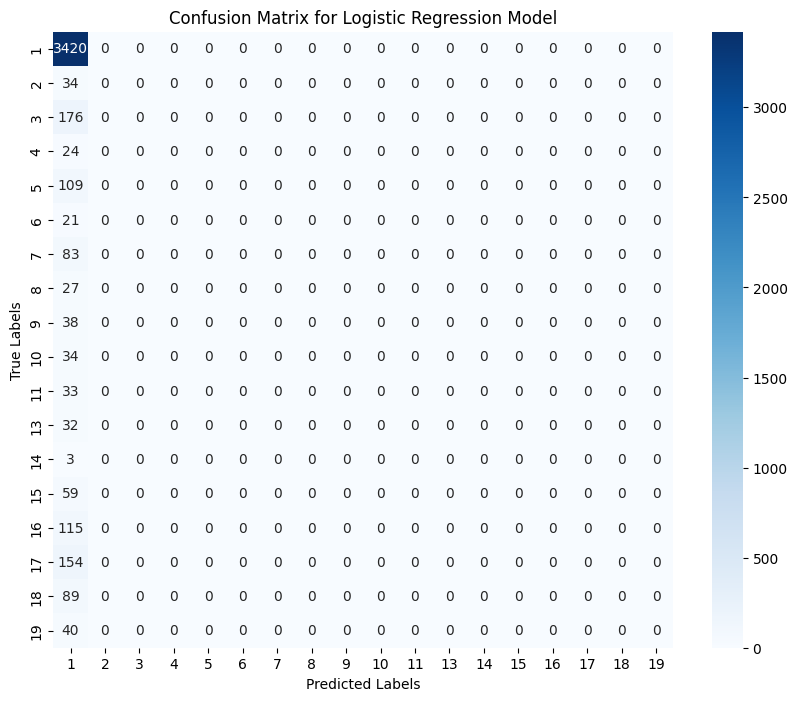

In [56]:
y_pred = scratch_model_eff.predict(test_ds.map(lambda img, label: (img, label)))
y_pred_binary = multi_label_threshold(y_pred, threshold_nb=3)

avg_precision = average_precision_score(y_true, y_pred, average="samples")
print(f"Mean Average Precision pour : {avg_precision:.4f}")

print("\nRapport de classification par classe:")
print(classification_report(y_true, y_pred_binary, target_names=train_df.columns[3:]))

confusion_matrice_multilabel(y_true, y_pred_binary, labels=train_df.columns[3:])

##### Compare

141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 60.4056
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - AUC: 0.4962 - accuracy: 0.7517 - loss: 4.2958
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - AUC: 0.4984 - accuracy: 0.7517 - loss: 574.3469
Comparaison des performances:
                        Modèle  Accuracy       AUC
0     EfficientNet - Transfert  0.752499  0.500000
1   EfficientNet - Fine-tuning  0.752499  0.500243
2  EfficientNet - From Scratch  0.752499  0.500000


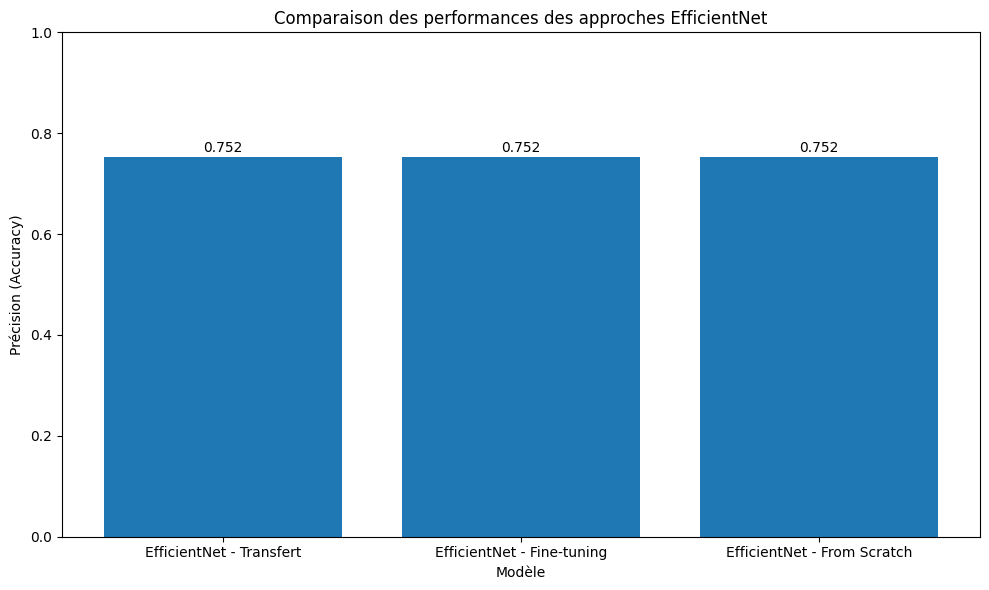

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Supposons que nous avons stocké les métriques d'évaluation
one = model_eff_transfer.evaluate(val_ds.map(lambda img, label: (img, label)))
two = model_eff_finetune.evaluate(val_ds.map(lambda img, label: (img, label)))
three = scratch_model_eff.evaluate(val_ds.map(lambda img, label: (img, label)))

metrics = {
    "Modèle": [
        "EfficientNet - Transfert",
        "EfficientNet - Fine-tuning",
        "EfficientNet - From Scratch",
    ],
    "Accuracy": [one[1], two[1], three[1]],
    "AUC": [one[2], two[2], three[2]],
}

df_metrics = pd.DataFrame(metrics)
print("Comparaison des performances:")
print(df_metrics)

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Modèle"], df_metrics["Accuracy"])
plt.title("Comparaison des performances des approches EfficientNet")
plt.xlabel("Modèle")
plt.ylabel("Précision (Accuracy)")
plt.ylim(0, 1)
for i, v in enumerate(df_metrics["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()

## Analyse des résultats

### Quelques exemples

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
True:Index(['1', '19'], dtype='object')
Pred:Index(['1'], dtype='object')
Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
True:Index(['1'], dtype='object')
Pred:Index(['1'], dtype='object')
Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True:Index(['1', '3'], dtype='object')
Pred:Index(['1'], dtype='object')
Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True:Index(['1'], dtype='object')
Pred:Index(['1'], dtype='object')
Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True:Index(['1', '3', '6'], dtype='object')
Pred:Index(['1'], dtype='object')
Pred: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 

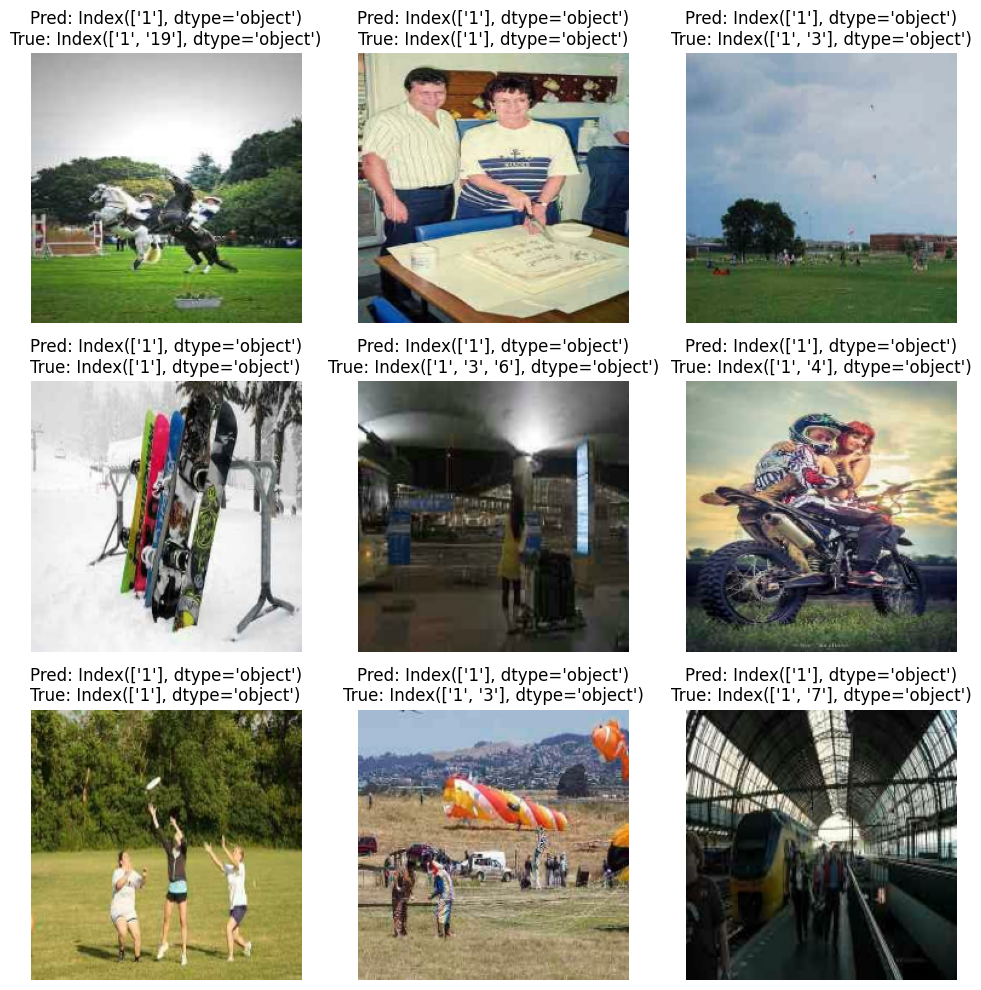

In [61]:
## Le transfert de poid du EfficientNet nous a donné le meilleur AUC


batch = next(iter(test_ds))

images_batch, labels_batch = batch
preds_img = model_eff_transfer.predict(images_batch)
plt.figure(figsize=(10, 10))

for i in range(min(9, images_batch.shape[0])):
    true_labels = train_df.iloc[:, 3:].columns[labels_batch[i] == 1]
    print(f"True:{true_labels}")
    predicted_labels = train_df.iloc[:, 3:].columns[preds_img[i] > 0.4]
    print(f"Pred:{predicted_labels}")
    print(f"Pred: {np.around(preds_img[i], 1)}\nTrue: {labels_batch[i]}")
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i])
    plt.title(f"Pred: {predicted_labels}\nTrue: {true_labels}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Explicability avec LIME

In [63]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=38b3d9f89b0e3832fec986ddd05a6949327512e2c8b6787c659b708988070c20
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━

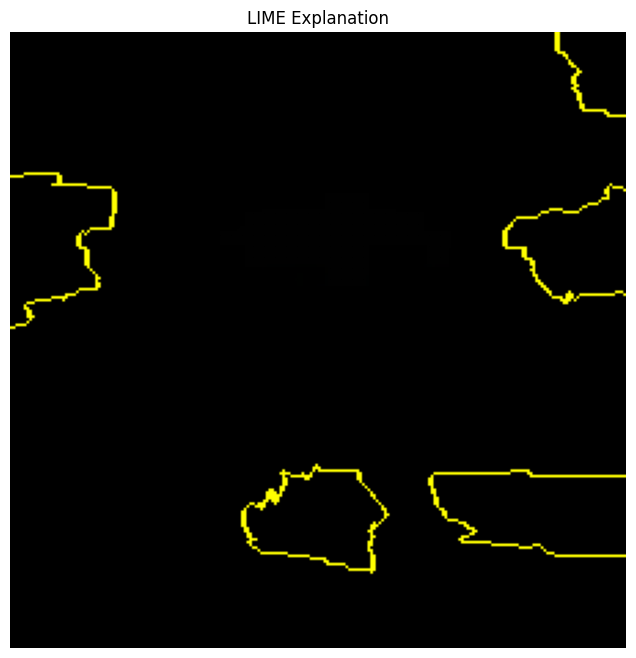

In [64]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np


explainer = lime_image.LimeImageExplainer()

# Select an image from the test dataset
for img, label in test_ds.take(1):
    img = img[0].numpy()
    label = label[0].numpy()


def predict_fn(images):
    return model.predict(images)


explanation = explainer.explain_instance(
    img.astype("double"), predict_fn, top_labels=3, hide_color=0, num_samples=1000
)


temp, mask = explanation.get_image_and_mask(
    label=np.argmax(label), positive_only=True, num_features=5, hide_rest=False
)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Example 0:
True Labels: Index(['1', '19'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


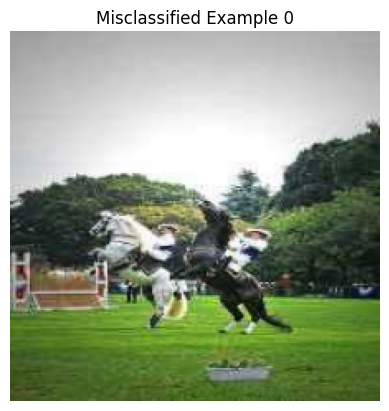

Example 1:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


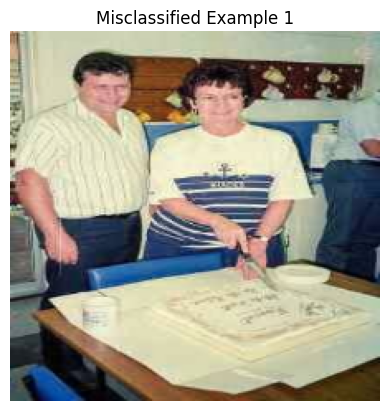

Example 2:
True Labels: Index(['1', '3'], dtype='object')
Predicted Labels: Index(['1', '3', '17'], dtype='object')


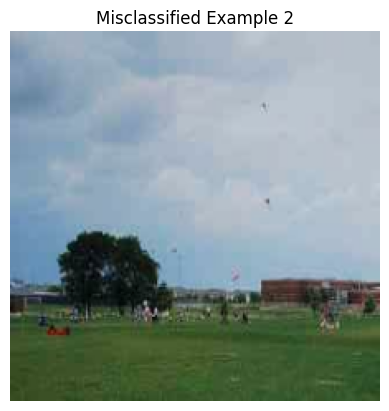

Example 3:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


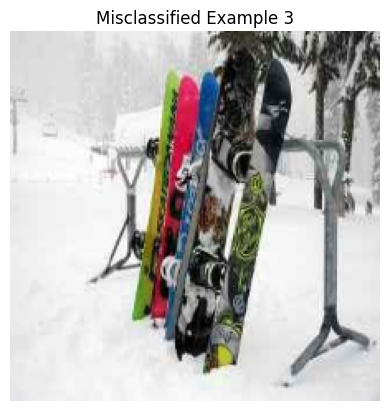

Example 4:
True Labels: Index(['1', '3', '6'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


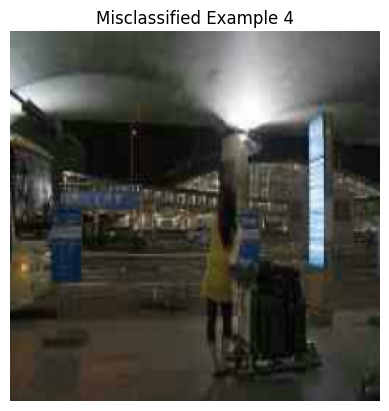

Example 5:
True Labels: Index(['1', '4'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


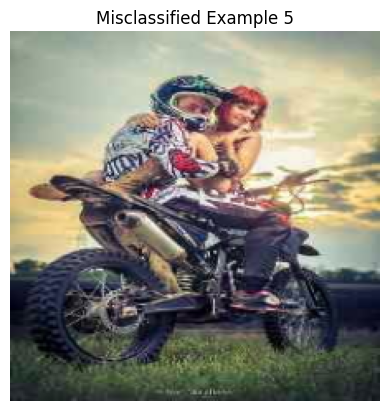

Example 6:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


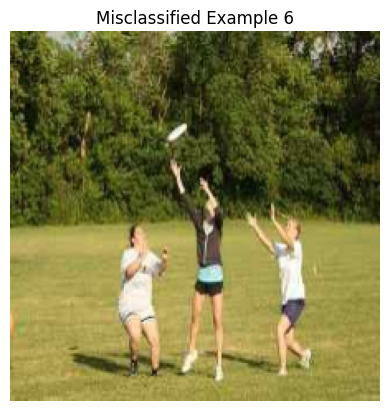

Example 7:
True Labels: Index(['1', '3'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


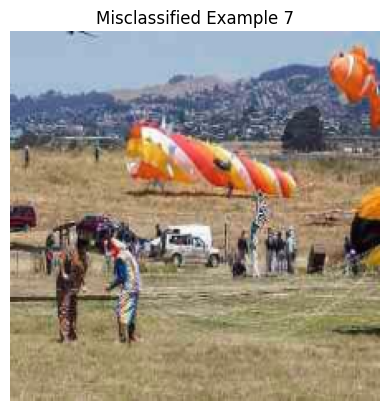

Example 8:
True Labels: Index(['1', '7'], dtype='object')
Predicted Labels: Index(['1', '3', '8'], dtype='object')


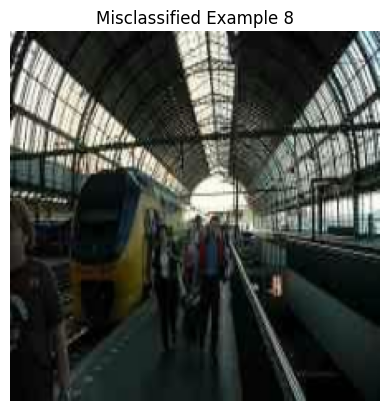

Example 9:
True Labels: Index(['16'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


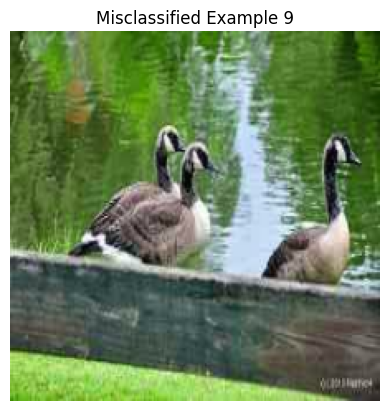

Example 10:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


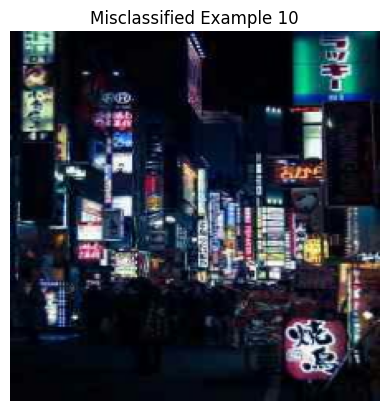

Example 11:
True Labels: Index(['1', '2'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


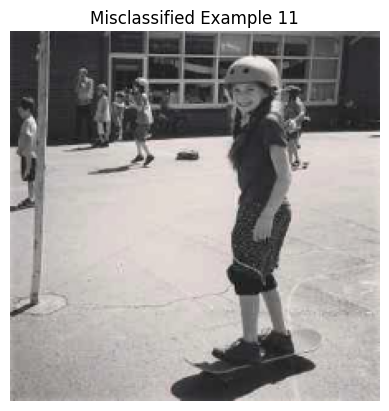

Example 12:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


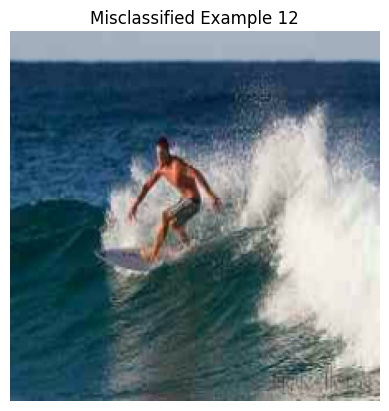

Example 13:
True Labels: Index(['3', '6'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


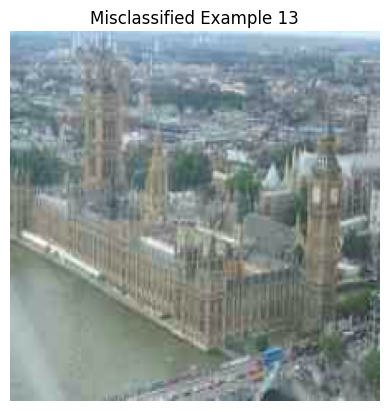

Example 14:
True Labels: Index(['11'], dtype='object')
Predicted Labels: Index(['1', '3', '17'], dtype='object')


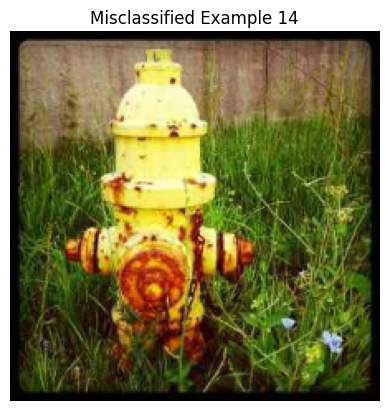

Example 15:
True Labels: Index(['3', '8', '10'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


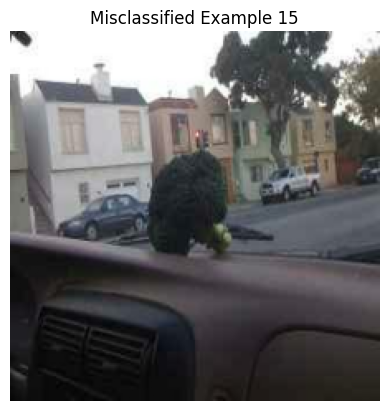

Example 16:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


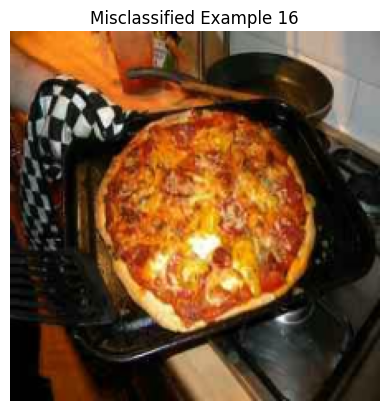

Example 17:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


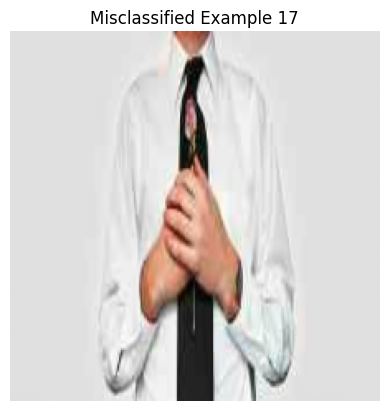

Example 18:
True Labels: Index(['18'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


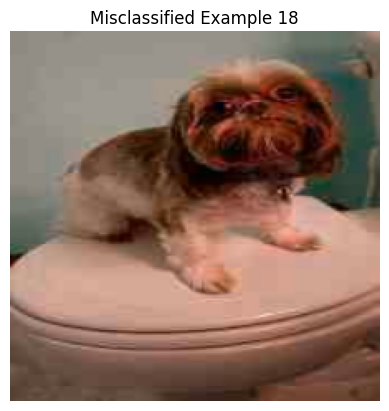

Example 19:
True Labels: Index(['1', '19'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


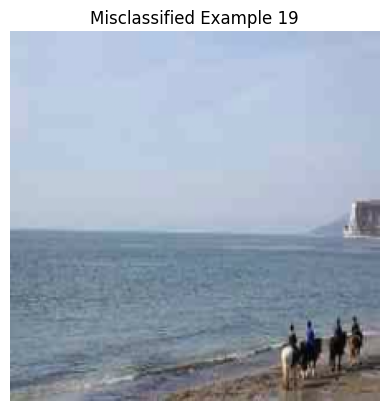

Example 20:
True Labels: Index(['7'], dtype='object')
Predicted Labels: Index(['1', '3', '6'], dtype='object')


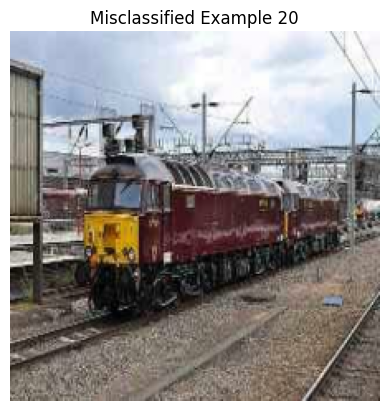

Example 21:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


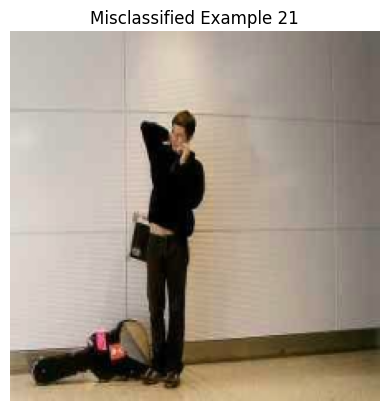

Example 22:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


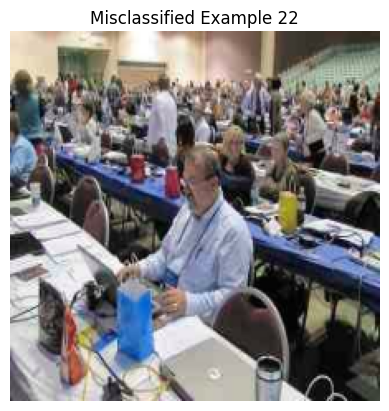

Example 23:
True Labels: Index(['1', '6'], dtype='object')
Predicted Labels: Index(['1', '3', '8'], dtype='object')


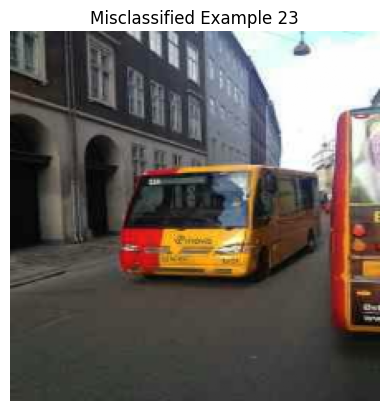

Example 24:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '15', '17'], dtype='object')


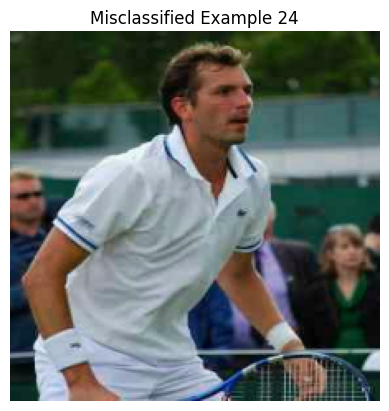

Example 25:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


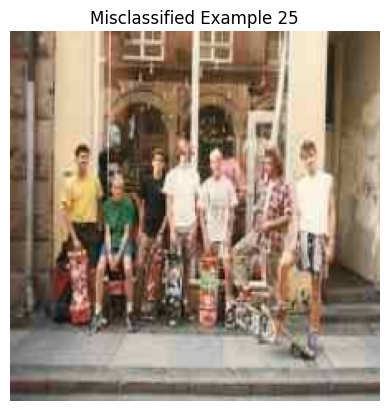

Example 26:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


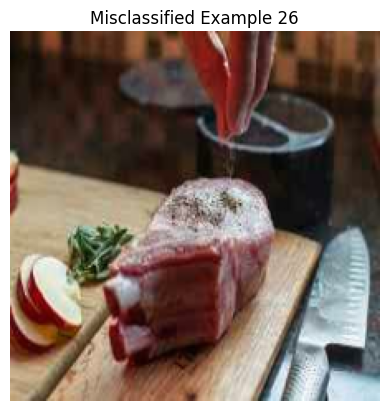

Example 27:
True Labels: Index(['1', '17'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


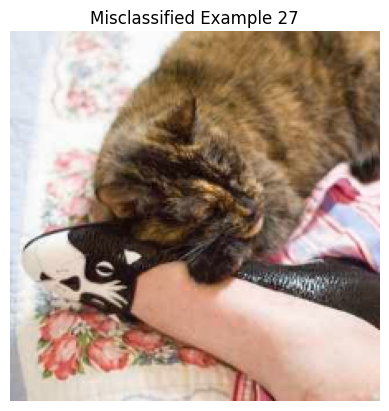

Example 28:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


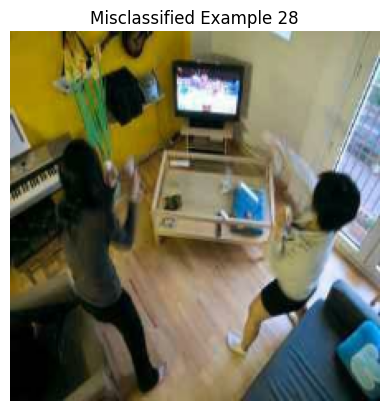

Example 29:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '3', '17'], dtype='object')


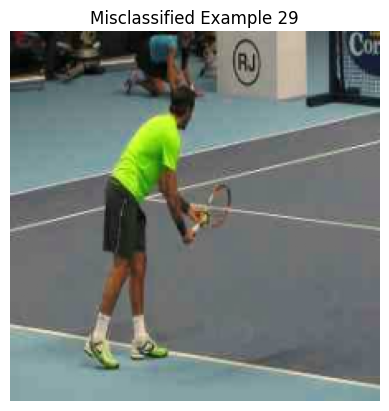

Example 30:
True Labels: Index(['1'], dtype='object')
Predicted Labels: Index(['1', '17', '18'], dtype='object')


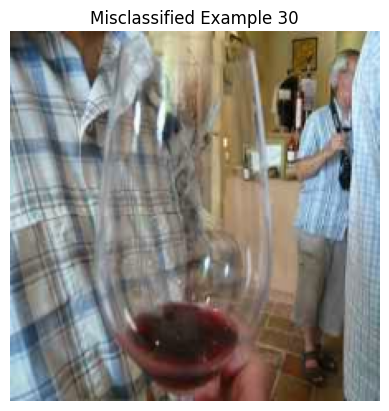

Example 31:
True Labels: Index(['17'], dtype='object')
Predicted Labels: Index(['1', '3', '15'], dtype='object')


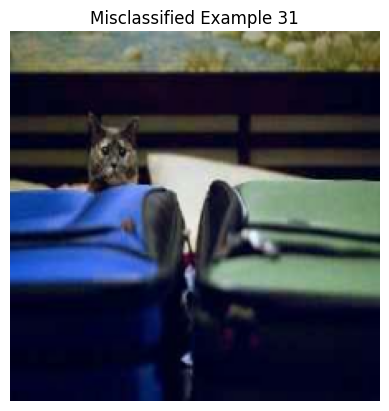

In [65]:
# Examine prediction errors
for img, label in test_ds.take(1):
    preds = model.predict(img)
    preds_binary = multi_label_threshold(preds, threshold_nb=3)
    true_labels = label.numpy()

    # Identify misclassified examples
    for i in range(len(true_labels)):
        if not np.array_equal(true_labels[i], preds_binary[i]):
            print(f"Example {i}:")
            print(f"True Labels: {train_df.columns[3:][true_labels[i] == 1]}")
            print(f"Predicted Labels: {train_df.columns[3:][preds_binary[i] == 1]}")
            plt.imshow(img[i].numpy())
            plt.title(f"Misclassified Example {i}")
            plt.axis("off")
            plt.show()

In [67]:
model_eff_transfer.save("model_eff_transfer.h5")